****
##### Sección *original* del código realizado.
****
En esta parte del documento se muestra el **proceso original** de cuando se creó el código. Cabe mencionar que aquí están todas las funciones juntas, sin separarse, y toda la lógica desarrollada.

En la siguiente parte del colab se muestra ya el orden final, cada función por separado y explicando específicamente que acción realiza y cómo la realiza, sin embargo se deja este bloque de código como una especie de "legado", de cómo empezaron los programadores de la comunidad 1 en el proceso creativo del código.

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image, ImageOps, ImageFilter
from functools import reduce
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

def hyperbolic_equalization(image):
    # convierte la imagen a escala de grises
    gray_image = ImageOps.grayscale(image)

    # obtener su histograma
    hist = gray_image.histogram()

    # Encontrar los valores minimos y maximos
    gmin = 0
    gmax = 255
    while hist[gmin] == 0:
        gmin += 1
    while hist[gmax] == 0:
        gmax -= 1

    # Calcular la distribucion acumulativa
    total_pixels = gray_image.width * gray_image.height
    cdf = [0] * 256

    sum_pixels = 0
    for pixel_value in range(gmin, gmax + 1):
        sum_pixels += hist[pixel_value]
        cdf[pixel_value] = sum_pixels

    # Guardar la imagen en un arreglo
    equalized_image = Image.new('L', gray_image.size)
    ecu_values = []

    # Realizar la ecualizacion hiperbolica en la imagen
    for x in range(gray_image.width):
        for y in range(gray_image.height):
            pixel_value = gray_image.getpixel((x, y))
            ecu_value = int(((cdf[pixel_value] - cdf[gmin]) / (total_pixels - cdf[gmin])) * (gmax - gmin) + gmin)
            ecu_values.append(ecu_value)
            equalized_image.putpixel((x, y), ecu_value)

    return equalized_image

def filtropromedio(image, kernel_size):
    # Obtener las dimensiones de la imagen
    ancho, alto = image.size

    # Crear una nueva imagen para el resultado del filtro promedio
    imagen_suavizada = Image.new('L', (ancho, alto))

    # Aplicar el filtro promedio
    for y in range(alto):
        for x in range(ancho):
            suma = 0
            contador = 0

            for j in range(-kernel_size // 2, kernel_size // 2 + 1):
                for i in range(-kernel_size // 2, kernel_size // 2 + 1):
                    if 0 <= x + i < ancho and 0 <= y + j < alto:
                        pixel_value = image.getpixel((x + i, y + j))
                        suma += pixel_value
                        contador += 1

            promedio = int(suma / contador)

            imagen_suavizada.putpixel((x, y), promedio)
    return imagen_suavizada

def sobel_operator(image):
    # Kernels de Sobel
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Crear una nueva imagen para el resultado del operador de Sobel
    sobel_result = Image.new('L', image.size)

    # Obtener las dimensiones de la imagen
    ancho, alto = image.size

    for y in range(1, alto - 1):
        for x in range(1, ancho - 1):
            # Aplicar el operador de Sobel a la vecindad de 3x3
            gx = np.sum(sobel_x * np.array([
                [image.getpixel((x - 1, y - 1)), image.getpixel((x, y - 1)), image.getpixel((x + 1, y - 1))],
                [image.getpixel((x - 1, y)), image.getpixel((x, y)), image.getpixel((x + 1, y))],
                [image.getpixel((x - 1, y + 1)), image.getpixel((x, y + 1)), image.getpixel((x + 1, y + 1))]
            ]))

            gy = np.sum(sobel_y * np.array([
                [image.getpixel((x - 1, y - 1)), image.getpixel((x, y - 1)), image.getpixel((x + 1, y - 1))],
                [image.getpixel((x - 1, y)), image.getpixel((x, y)), image.getpixel((x + 1, y))],
                [image.getpixel((x - 1, y + 1)), image.getpixel((x, y + 1)), image.getpixel((x + 1, y + 1))]
            ]))

            # Calcular la magnitud del gradiente
            gradient_magnitude = int(np.sqrt(gx**2 + gy**2))

            sobel_result.putpixel((x, y), gradient_magnitude)

    return sobel_result

def convertir_a_blanco_y_negro(image, umbral=128):
    # Convierte la imagen a escala de grises si no lo está
    if image.mode != 'L':
        image = ImageOps.grayscale(image)

    # Aplicar el umbral para convertir a blanco y negro
    image_bn = image.point(lambda p: p > umbral and 255)

    return image_bn

def apply_negative(image):
    # Invertir los valores de los píxeles
    inverted_image = ImageOps.invert(image)
    return inverted_image

def apply_threshold(image, threshold=128):
    # Convierte la imagen a escala de grises si no lo está
    if image.mode != 'L':
        image = ImageOps.grayscale(image)

    # Aplicar el umbral para convertir a blanco y negro
    thresholded_image = image.point(lambda p: p > threshold and 255)

    return thresholded_image

rutaImagen = '/content/der.jpg'
rutaSegmentacionSenoIzq = '/content/segmentada3.png'

imagen = cv2.imread(rutaImagen)
segmentacion = cv2.imread(rutaSegmentacionSenoIzq)
print('Imagen original')
cv2_imshow(imagen)
print('Imagen segmentada')
cv2_imshow(segmentacion)

# Convertir la imagen segmentada a escala de grises
imagen_segmentada_gris = cv2.cvtColor(segmentacion, cv2.COLOR_BGR2GRAY)

# Aplicar un umbral para obtener una imagen binaria de la segmentación
_, mascara = cv2.threshold(imagen_segmentada_gris, 1, 255, cv2.THRESH_BINARY)

# Aplicar la máscara a la imagen original para extraer la región
resultado = cv2.bitwise_and(imagen, imagen, mask=mascara)
print('Imagen aplicando mascara')
cv2_imshow(resultado)

imagenSinRuido = cv2.medianBlur(resultado, ksize=5)
print('Imagen Sin ruido')
cv2_imshow(imagenSinRuido)
print('Imagen Limpia')
cv2.imwrite('ImagenLimpia.jpg', imagenSinRuido)

# Cargar la imagen usando Pillow (PIL)
imagen = Image.open('/content/ImagenLimpia.jpg')

# Convertir la imagen de Pillow a un arreglo NumPy
imagen = np.array(imagen)

imagen = cv2.medianBlur(imagen, ksize=5)
imagen = Image.fromarray(imagen)
#escala grises
imagen = ImageOps.grayscale(imagen)

# Aplicar el negativo a la imagen original
imagen = apply_negative(imagen)

# Definir las funciones en una lista
functions = [hyperbolic_equalization, filtropromedio, sobel_operator]

# Crear una lista de cadenas para mostrar las opciones al usuario
function_names = ["Ecualizar la imagen", "Filtro Promedio", "Filtro Sobel"]

# Crear una lista para almacenar el orden de las funciones
selected_order = []

# Mostrar las opciones disponibles al usuario
print("Seleccione el orden en el que desea aplicar las funciones:")
for i, function_name in enumerate(function_names, start=1):
    print(f"{i}. {function_name}")

# Solicitar al usuario que ingrese el orden deseado
order_input = input("Ingrese el orden deseado (por ejemplo, 1 3 2): ")
order_input = order_input.split()  # Convertir la entrada en una lista de números

# Convertir los números en la lista de entrada a funciones y almacenarlas en selected_order
for order in order_input:
    if order.isdigit and int(order) in range(1, len(functions) + 1):
        selected_order.append(functions[int(order) - 1])
    else:
        print(f"El número {order} no es una opción válida. Ignorado.")

# Crear una lista para almacenar las imágenes resultantes y los histogramas
result_images = [imagen]  # Comenzamos con la imagen original
histograms = []

for func in selected_order:
    if func == filtropromedio:
        kernel_size = 3
        result_image = func(result_images[-1], kernel_size)
    else:
        result_image = func(result_images[-1])
    result_images.append(result_image)

    # Calcular el histograma de la imagen resultante
    hist, _ = np.histogram(np.array(result_image).ravel(), bins=256, range=(0, 256), density=True)
    histograms.append(hist)

# Crear un gráfico para mostrar las imágenes y sus histogramas
num_functions = len(selected_order)
plt.figure(figsize=(20, 5 * num_functions))

for i in range(num_functions):
    # Mostrar la imagen resultante
    plt.subplot(num_functions, 2, i * 2 + 1)
    plt.imshow(result_images[i + 1], cmap='gray')
    plt.title(f"Resultado de {function_names[selected_order.index(selected_order[i])]}")

    # Mostrar el histograma de la imagen resultante
    plt.subplot(num_functions, 2, i * 2 + 2)
    plt.plot(histograms[i], color='r')
    plt.title(f"Histograma de {function_names[selected_order.index(selected_order[i])]}")
    plt.xlim(0, 256)

plt.show()

# Obtener la última imagen generada
ultima_imagen = result_images[1]

# Mostrar la imagen en blanco y negro
plt.figure(figsize=(5, 5))
plt.imshow(ultima_imagen, cmap='gray')
plt.title("Imagen en Blanco y Negro")
plt.show()

# Convertir la imagen de Pillow (PIL) en una matriz de NumPy
ultima_imagen_np = np.array(ultima_imagen)

# Aplicar umbral a la imagen
_, area = cv2.threshold(ultima_imagen_np, 230, 255, cv2.THRESH_BINARY)
print('Imagen umbralizada')
cv2_imshow(area)

# Encontrar contornos en la imagen en escala de grises
contornos, _ = cv2.findContours(area, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Crear una imagen en blanco para dibujar los contornos
contornos_img = np.zeros_like(ultima_imagen_np)

# Dibujar los contornos en la imagen en blanco
cv2.drawContours(contornos_img, contornos, -1, (0, 0, 255), thickness=1)

# Mostrar la imagen con los bordes dibujados
print('Imagen contornos')
cv2_imshow(contornos_img)

print('Dado que nuestro filtro no limpia todo el ruido procedemos a repetir el proceso pero ahora con Filtro Gaussiano')

# Aplicar umbral a la imagen
_, area = cv2.threshold(imagenSinRuido, 230, 255, cv2.THRESH_BINARY)
print('Imagen umbralizada')
cv2_imshow(area)

area_gray = cv2.cvtColor(area, cv2.COLOR_BGR2GRAY)

# Encontrar contornos en la imagen en escala de grises
contornos, _ = cv2.findContours(area_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Crear una imagen en blanco para dibujar los contornos
contornos_img = np.zeros_like(imagenSinRuido)

# Dibujar los contornos en la imagen en blanco
cv2.drawContours(contornos_img, contornos, -1, (0, 0, 255), thickness=1)

# Mostrar la imagen con los bordes dibujados
rutaImagen = '/content/der.jpg'
imagen = cv2.imread(rutaImagen)
print('Imagen contornos final')
cv2_imshow(contornos_img)


Imagen original


AttributeError: ignored

****
# **Información importante**
****
En la elaboración de los algoritmos de la comunidad 1 nos percatamos que no resolvía el problema por sí solo, lamentablemente. Por esta razón se utilizó código proporcionado por las demás comunidades que utilizaron diferentes técnicas y programaron las mismas.

Se les agradece mucho por su aporte.
****
**Los métodos utilizados de otras comunidades son:**

1.   Filtro mediana.
2.   Filtro Robinson.
3.   Corrección Gamma.
4.   Filtro PasoBaja
5.   Obtención contorno.

Así pues demos inicio a la resolución de la problemática.

****
# **Import Requirements:**
****
*   **"pyplot":**  Es un submódulo dentro de Matplotlib que proporciona una interfaz similar a la de MATLAB para crear gráficos de manera rápida y sencilla.
*   **"Image":** Es la parte principal del módulo PIL y proporciona clases y métodos para trabajar con imágenes. Permite cargar imágenes, manipular sus propiedades, aplicar transformaciones, realizar operaciones de píxeles, entre otras tareas de procesamiento de imágenes.
*   **"ImageOps":** Es un módulo dentro de PIL que contiene varias operaciones estándar para manipular imágenes, como ajustes de tamaño, rotación, volteo, inversiones de color, cambios de brillo y contraste, entre otros.
*   **"ImageFilter":** Es otro módulo dentro de PIL que proporciona una serie de filtros predefinidos para aplicar a las imágenes, como filtros de desenfoque, nitidez, detección de bordes, entre otros, para modificar la apariencia de las imágenes.
*   **"reduce":** Se utilizaba para aplicar una función específica de manera sucesiva a los elementos de una secuencia (por ejemplo, una lista) para reducirla a un solo valor.
*   **"numpy":** NumPy es una biblioteca fundamental en Python para trabajar con arreglos numéricos y realizar operaciones matemáticas y numéricas eficientes.
*   **"cv2":** OpenCV es una biblioteca ampliamente utilizada en aplicaciones de visión por computadora para el procesamiento de imágenes y videos.
*   **"cv2_imshow":** La función cv2_imshow se utiliza para mostrar imágenes en un entorno de notebook de Google Colab, y está diseñada para ser utilizada con imágenes que se cargan o se procesan utilizando OpenCV (Open Source Computer Vision Library).

In [ ]:
from matplotlib import pyplot as plt
from PIL import Image, ImageOps, ImageFilter
from functools import reduce
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

****
# **Ecualización Hiperbólica**
****
La ecualización hiperbólica es un método de procesamiento de imágenes que se utiliza para ajustar el contraste de una imagen. En lugar de expandir linealmente el histograma de una imagen, como lo hace la ecualización de histograma convencional, la ecualización hiperbólica busca resaltar más los detalles en áreas de baja intensidad mientras conserva información en áreas de alta intensidad.

Originalmente, en el desarrollo de esta función se utilizó la fórmula dada por la profesora, la cual es esta:
![Imagen tomada en clase de PDI, seleccionado con color negro la parte de interés; circa 2023.](/content/ecHiperbolica.jpg)

Sin embargo se tuvieron muchos problemas con esta ya que no realizaba los cambios pertinentes. Con esto en mente, se modificó la función matemática por otra equivalente pero expresada de manera diferente.
****
##### **Pasos para la aplicación de la ecualización hiperbólica en orden:**

1.   Recibe la imagen.
2.   Convierte la imagen a escala de grises.
3.   Obtiene el histograma de la imagen.
4.   Encuentra los valores mínimos y máximos de la imagen.
5.   Calcula la distribución acumulativa de la imagen.
6.   Guarda la imagen en un arreglo.
7.   Realiza la ecualización hiperbólica en una imagen.
8.   Retorna la imagen ya ecualizada.

In [ ]:
def hyperbolic_equalization(image):
    # convierte la imagen a escala de grises
    gray_image = ImageOps.grayscale(image)

    # obtener su histograma
    hist = gray_image.histogram()

    # Encontrar los valores minimos y maximos
    gmin = 0
    gmax = 255
    while hist[gmin] == 0:
        gmin += 1
    while hist[gmax] == 0:
        gmax -= 1

    # Calcular la distribucion acumulativa
    total_pixels = gray_image.width * gray_image.height
    cdf = [0] * 256

    sum_pixels = 0
    for pixel_value in range(gmin, gmax + 1):
        sum_pixels += hist[pixel_value]
        cdf[pixel_value] = sum_pixels

    # Guardar la imagen en un arreglo
    equalized_image = Image.new('L', gray_image.size)
    ecu_values = []

    # Realizar la ecualizacion hiperbolica en la imagen
    for x in range(gray_image.width):
        for y in range(gray_image.height):
            pixel_value = gray_image.getpixel((x, y))
            ecu_value = int(((cdf[pixel_value] - cdf[gmin]) / (total_pixels - cdf[gmin])) * (gmax - gmin) + gmin)
            ecu_values.append(ecu_value)
            equalized_image.putpixel((x, y), ecu_value)

    return equalized_image

****
# **Filtro Promedio**
****
El filtro promedio, también conocido como filtro de media o filtro de suavizado, es una técnica de procesamiento de imágenes que se utiliza para suavizar una imagen al promediar los valores de los píxeles en una región específica. Este filtro se aplica convolucionando la imagen original con una matriz de pesos, donde cada peso corresponde al promedio de los valores de píxeles en una vecindad determinada.
****
##### **Pasos para la aplicación del filtro promedio en orden:**

1.   Recibe la imagen y el tamaño de la vecindad.
2.   Obtiene las dimensiones de la imagen (ancho y alto).
3.   Aplica el filtro promedio tomando en cuenta las dimensiones de la imagen.
4.   Retorna la imagen ya filtrada.



In [ ]:
def filtropromedio(image, kernel_size):
    # Obtener las dimensiones de la imagen
    ancho, alto = image.size

    # Crear una nueva imagen para el resultado del filtro promedio
    imagen_suavizada = Image.new('L', (ancho, alto))

    # Aplicar el filtro promedio
    for y in range(alto):
        for x in range(ancho):
            suma = 0
            contador = 0

            for j in range(-kernel_size // 2, kernel_size // 2 + 1):
                for i in range(-kernel_size // 2, kernel_size // 2 + 1):
                    if 0 <= x + i < ancho and 0 <= y + j < alto:
                        pixel_value = image.getpixel((x + i, y + j))
                        suma += pixel_value
                        contador += 1

            promedio = int(suma / contador)

            imagen_suavizada.putpixel((x, y), promedio)
    return imagen_suavizada

****
# **Filtro Sobel**
****
El filtro de Sobel es un operador utilizado en el procesamiento de imágenes para resaltar los bordes de la imagen. Es especialmente eficaz para detectar bordes verticales y horizontales. Este filtro utiliza máscaras o kernels para calcular las aproximaciones de las derivadas parciales de la imagen respecto a la dirección horizontal (Sobel horizontal) y vertical (Sobel vertical). Luego, se combina la información de ambas direcciones para obtener una magnitud de gradiente que destaca los bordes.
****
##### **Pasos para la aplicación del filtro de Sobel en orden:**

1.   Recibe la imagen.
2.   Inicializa ambos kernels de Sobel, para "x" y para "y".
3.   Crea una nueva imagen para el resultado del operador de Sobel.
4.   Obtiene las dimensiones de la imagen.
5.   Aplica el filtro de sobel a la vecindad de 3x3.
6.   Calcula la magnitud del gradiente.
7.   Retorna la imagen procesada.



In [ ]:
def sobel_operator(image):
    # Kernels de Sobel
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Crear una nueva imagen para el resultado del operador de Sobel
    sobel_result = Image.new('L', image.size)

    # Obtener las dimensiones de la imagen
    ancho, alto = image.size

    for y in range(1, alto - 1):
        for x in range(1, ancho - 1):
            # Aplicar el operador de Sobel a la vecindad de 3x3
            gx = np.sum(sobel_x * np.array([
                [image.getpixel((x - 1, y - 1)), image.getpixel((x, y - 1)), image.getpixel((x + 1, y - 1))],
                [image.getpixel((x - 1, y)), image.getpixel((x, y)), image.getpixel((x + 1, y))],
                [image.getpixel((x - 1, y + 1)), image.getpixel((x, y + 1)), image.getpixel((x + 1, y + 1))]
            ]))

            gy = np.sum(sobel_y * np.array([
                [image.getpixel((x - 1, y - 1)), image.getpixel((x, y - 1)), image.getpixel((x + 1, y - 1))],
                [image.getpixel((x - 1, y)), image.getpixel((x, y)), image.getpixel((x + 1, y))],
                [image.getpixel((x - 1, y + 1)), image.getpixel((x, y + 1)), image.getpixel((x + 1, y + 1))]
            ]))

            # Calcular la magnitud del gradiente
            gradient_magnitude = int(np.sqrt(gx**2 + gy**2))

            sobel_result.putpixel((x, y), gradient_magnitude)

    return sobel_result

****
# **Aplicar Negativo**
****
El negativo de una imagen es una versión invertida de la imagen original en términos de colores. En un negativo, los colores que eran originalmente claros aparecen oscuros y viceversa.
****
##### **Pasos para la aplicación del negativo de la imagen en orden:**

1.   Recibe la imagen.
2.   Invierte los valores de los píxeles de la imagen.
3.   Retorna la imagen ya en negativo.



In [ ]:
def apply_negative(image):
    # Invertir los valores de los píxeles
    inverted_image = ImageOps.invert(image)
    return inverted_image

****
# **Filtro Mediana**
****
El filtro de mediana es un tipo de filtro utilizado en el procesamiento de imágenes para suavizar o reducir el ruido sin perder detalles importantes, como suele ocurrir con algunos otros filtros de suavizado. A diferencia de los filtros de promedio que calculan la media de los píxeles en una vecindad, el filtro de mediana calcula el valor mediano.
****
##### **Pasos para la aplicación del filtro mediana en orden:**

1.   Recibe la imagen
2.   Pregunta si si hay una imagen.
3.   Si hay imagen, crea una copia de la matriz original de la imagen; si no hay imagen, no realiza ninguna acción nada.
4.   Imprime "Se crea copia de la matriz".
5.   Asigna al kernel un tamaño de 35.
6.   Llama a la funcion medianBlur de cv2, que recibe la matriz del paso 3 y el tamaño del kernel del paso 5.
7.   Retorna la imagen resultante.

In [ ]:
def filtroMediana(imagen):
    if imagen is not None:
        matriz_gris = imagen.copy()  # Crear una copia de la matriz original
        print("Se crea copia de la matriz")
        kernel_size=35
        imagen_resultante=cv2.medianBlur(matriz_gris,kernel_size)
        return(imagen_resultante)

****
# **Filtro Robinson**
****
El filtro de Robinson es un operador de detección de bordes utilizado en el procesamiento de imágenes. Al igual que el filtro de Sobel, el filtro de Robinson se utiliza para resaltar los bordes de una imagen mediante la detección de cambios abruptos en la intensidad de los píxeles. Es particularmente eficaz para identificar bordes en direcciones diagonales.
****
##### **Pasos para la aplicación del filtro Robinson en orden:**

1.   Recibe imagen, dirección y grado.
2.   Crea una copia de la imagen.
3.   Pregunta si el modulo de dirección con respecto a 2 es igual a cero.
4.   Si es verdadero el punto 3, se crea el kernel que llamaremos kernel1. En otro, se crea el kernel que llamaremos kernel2.
5.   Se rota el kernel (el que se creó) 90 grados con respecto a la dirección.
6.   Se le resta al valor máximo de la matriz un 1.
7.   Aplica el filtro Robinson.
8.   Retorna la imagen.

In [ ]:
def robinson(imagen, direction, grade):
    img = imagen.copy()

    if direction % 2 == 0:
        rob_n = np.array([[-1, -grade, -1],
                          [0, 0, 0],
                          [1, grade, 1]])
    else:
        rob_n = np.array([[0, -1, -grade],
                          [1, 0, -1],
                          [grade, 1, 0]])

    rob_n = np.rot90(rob_n, k=int(direction/2))

    imax = np.max(img) - 1

    for i in range(imagen.shape[0] - 2):
        for j in range(imagen.shape[1] - 2):
            kernel = imagen[i:i+3, j:j+3]
            img[i+1][j+1] = imax/2 + np.sum(np.multiply(kernel, rob_n))

    return img

****
# **Corrección Gamma**
****
La corrección gamma es una técnica utilizada en el procesamiento de imágenes para ajustar la luminancia de una imagen, principalmente con el propósito de corregir o alterar la relación de contraste perceptual. Esta corrección está basada en la función de transferencia de gamma, que relaciona los niveles de intensidad de píxeles en la imagen original con los niveles de intensidad en la imagen corregida.

En términos generales:

Si γ > 1: Se produce una corrección gamma mayor que 1, lo que resulta en una imagen más oscura. Este ajuste puede ayudar a resaltar detalles en las áreas más oscuras de la imagen.

Si γ < 1: Se produce una corrección gamma menor que 1, lo que resulta en una imagen más clara. Este ajuste puede ser útil para resaltar detalles en áreas más brillantes de la imagen.
****
##### **Pasos para la aplicación de la corrección Gamma en orden:**

1.   Recibe imagen y parámetro Gamma.
2.   Crea una copia de la imagen.
3.   Crea una variable llamada imax y se iguala a 0.
4.   itera la imagen y se compara con imax, si el valor de ese pixel es mayor entonces imax se iguala a ese valor.
5.   Aplica el operador Gamma a la imagen.
6.   Retorna la imagen.

In [ ]:
def gammaC(imagen, gamma):
    """
    Aplica corrección gamma a una imagen
    Parametros:
      imagen(numpy.ndarray): Imagen Original
      gamma(float): Factor gamma
    Devuelve:
      img: Imagen con la corrección gamma
    """
    img = imagen.copy()
    imax = 0
    for i in img:
        if np.max(i) > imax:
            imax = np.max(i)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            img[i][j] = (imax - 1) * (img[i][j] / (imax - 1))**gamma
    return img

****
# **Filtro PasoBaja**
****
El filtro pasobaja reduce la variación rápida de intensidad en una imagen, lo que tiene el efecto de suavizar la imagen. La operación básica de un filtro pasobaja implica la convolución de la imagen original con un kernel diseñado para suavizar o promediar los valores de píxeles en una región local de la imagen.
****
##### **Pasos para la aplicación del filtro PasoBaja en orden:**

1.   Recibe la imagen.
2.   Crea una copia de la imagen.
3.   Utiliza GaussianBlur de cv2 para aplicar el filtro Gaussiano.
4.   Retorna la imagen filtrada.



In [ ]:
def aplicar_filtro_paso_bajo(imagen):
    """
    Filtra el ruido
    Parametros:
      image(numpy.ndarray): Imagen con ruido
    Devuelve:
      img(numpy.ndarray): Imagen sin ruido
    """
    img = imagen.copy()
    img_filtrada = cv2.GaussianBlur(img, (5, 5), 0)
    return img_filtrada

****
# **Segmentacion**
****
En esta parte del código se limpiará el ruido de la imagen (las letras, etc) aplicando las diferentes técnicas anteriormente descritas.

Se crea copia de la matriz


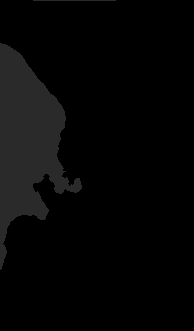

DIRECCION: 0    GRADO: 0 

Se crea copia de la matriz


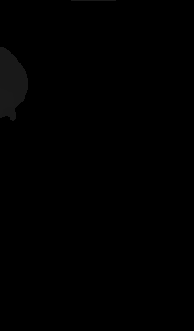

DIRECCION: 0    GRADO: 1 

Se crea copia de la matriz


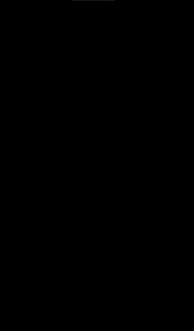

DIRECCION: 0    GRADO: 2 

Se crea copia de la matriz


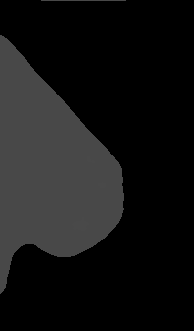

DIRECCION: 1    GRADO: 0 

Se crea copia de la matriz


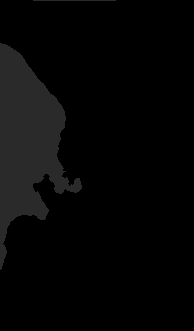

DIRECCION: 1    GRADO: 1 

Se crea copia de la matriz


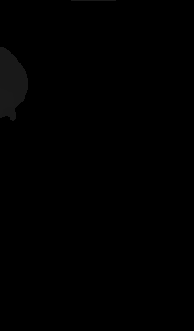

DIRECCION: 1    GRADO: 2 

Se crea copia de la matriz


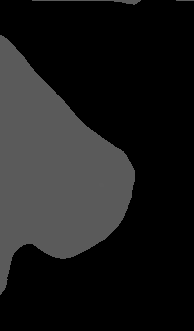

DIRECCION: 2    GRADO: 0 

Se crea copia de la matriz


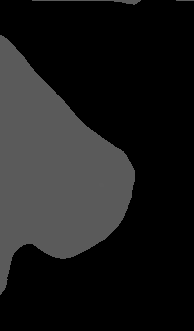

DIRECCION: 2    GRADO: 1 

Se crea copia de la matriz


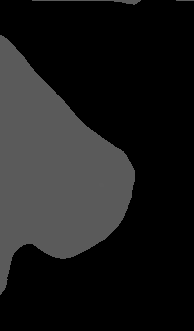

DIRECCION: 2    GRADO: 2 

Se crea copia de la matriz


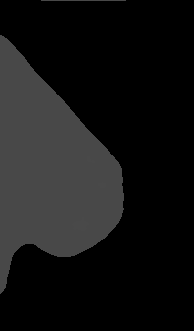

DIRECCION: 3    GRADO: 0 

Se crea copia de la matriz


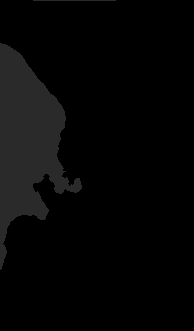

DIRECCION: 3    GRADO: 1 

Se crea copia de la matriz


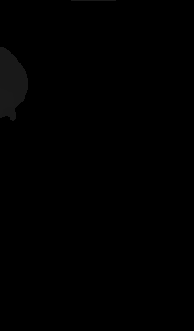

DIRECCION: 3    GRADO: 2 

Se crea copia de la matriz


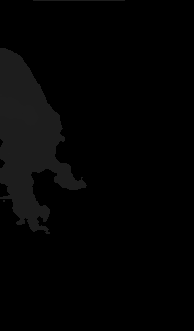

DIRECCION: 4    GRADO: 0 

Se crea copia de la matriz


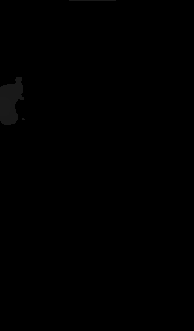

DIRECCION: 4    GRADO: 1 

Se crea copia de la matriz


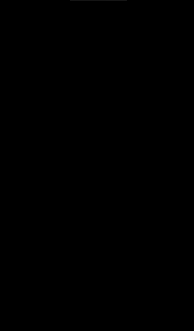

DIRECCION: 4    GRADO: 2 

Se crea copia de la matriz


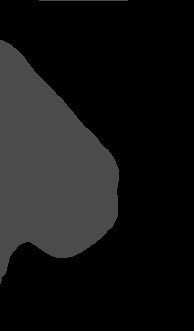

DIRECCION: 5    GRADO: 0 

Se crea copia de la matriz


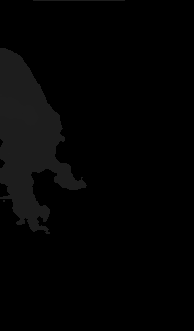

DIRECCION: 5    GRADO: 1 

Se crea copia de la matriz


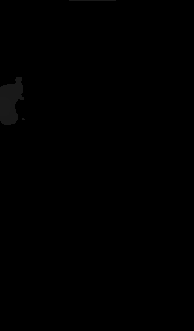

DIRECCION: 5    GRADO: 2 

Se crea copia de la matriz


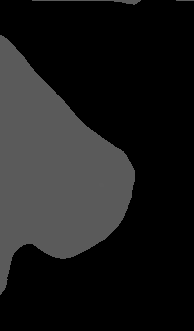

DIRECCION: 6    GRADO: 0 

Se crea copia de la matriz


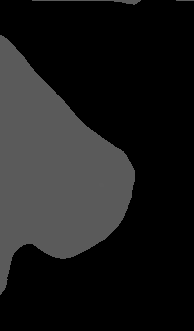

DIRECCION: 6    GRADO: 1 

Se crea copia de la matriz


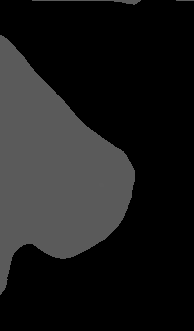

DIRECCION: 6    GRADO: 2 



In [ ]:
rutaImagen = '/content/der.jpg'
rutaSegmentacionSenoIzq = '/content/mejorintento.jpg';
imagen = cv2.imread(rutaImagen)
gc=imagen
img_bin=gc.copy()

for i in range(7):
  for j in range(3):
    segmented =robinson(imagen, i, j)
    gamma_seg=gammaC(segmented, 15.55)
    img_final=aplicar_filtro_paso_bajo(gamma_seg)
    img_final_neg=1-img_final
    neg_img_final = 255 - img_final_neg
    suma=cv2.subtract(gc,img_final_neg)
    suma=gammaC(suma,10)
    suma=gammaC(suma,0.5)
    suma=filtroMediana(suma)
    suma=gammaC(suma,0.001)
    cv2_imshow(suma)
    print(f"DIRECCION: {i}    GRADO: {j} \n")
    if i==0 and j==0:
      img_bin=suma
    if i == 6 and j == 2:
      cv2.imwrite('/content/segmentada3.png', suma)

****
# **Aplicación Filtro Robinson**
****
En esta parte del código se utilizará el anteriormente mencionado filtro robinson y se harán las pruebas con los diferentes valores que puede tomar cada vez.

Posteriormente, se imprimirá el resultado de cada una de ellas.

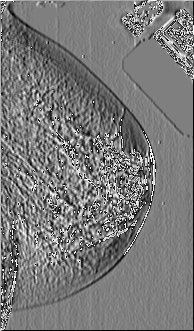

DIRECCION: 0    GRADO: 0 



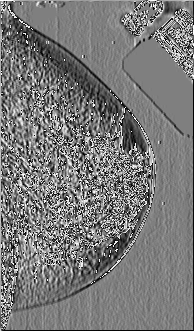

DIRECCION: 0    GRADO: 1 



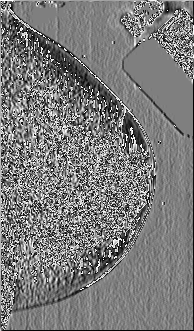

DIRECCION: 0    GRADO: 2 



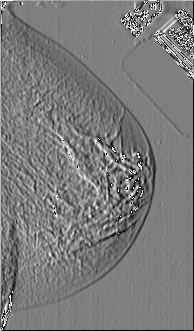

DIRECCION: 1    GRADO: 0 



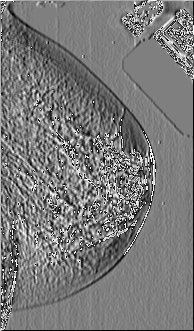

DIRECCION: 1    GRADO: 1 



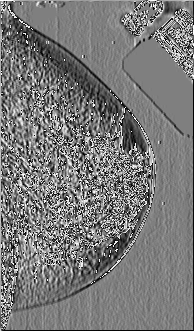

DIRECCION: 1    GRADO: 2 



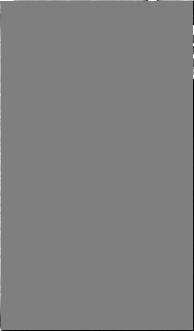

DIRECCION: 2    GRADO: 0 



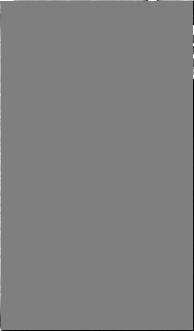

DIRECCION: 2    GRADO: 1 



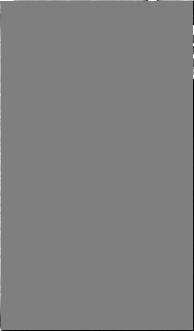

DIRECCION: 2    GRADO: 2 



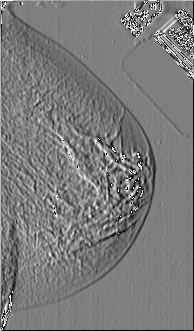

DIRECCION: 3    GRADO: 0 



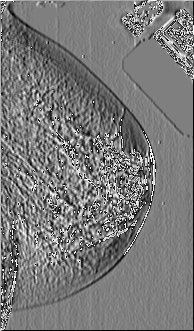

DIRECCION: 3    GRADO: 1 



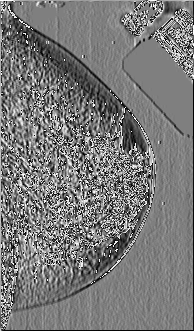

DIRECCION: 3    GRADO: 2 



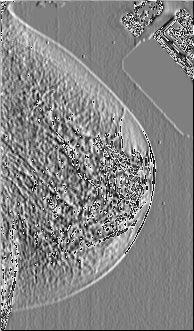

DIRECCION: 4    GRADO: 0 



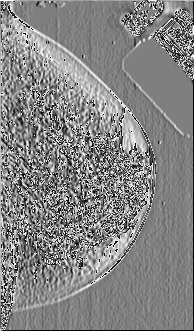

DIRECCION: 4    GRADO: 1 



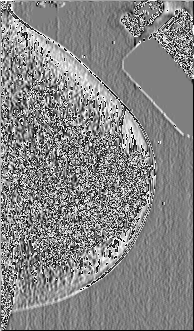

DIRECCION: 4    GRADO: 2 



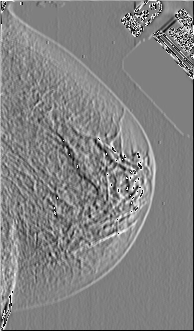

DIRECCION: 5    GRADO: 0 



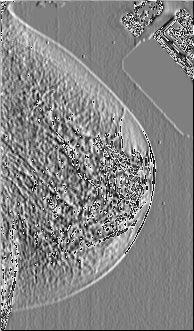

DIRECCION: 5    GRADO: 1 



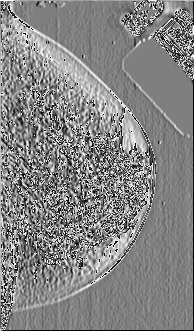

DIRECCION: 5    GRADO: 2 



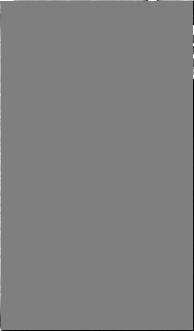

DIRECCION: 6    GRADO: 0 



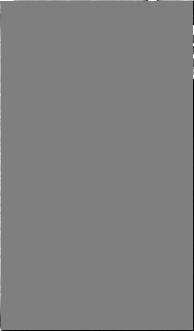

DIRECCION: 6    GRADO: 1 



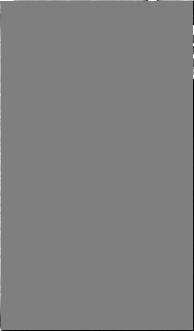

DIRECCION: 6    GRADO: 2 



In [ ]:
for i in range(7):
    for j in range(3):
        segmented = robinson(imagen, i, j)
        cv2_imshow(segmented)
        print(f"DIRECCION: {i}    GRADO: {j} \n")

****
# **Leer Imagen e Imagen segmentada**
****
Aquí no se especifica una función en específico, solamente se abren ambas imágenes y se enseñan de manera visual para demostrar el proceso que se aplicará.

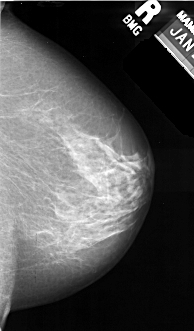

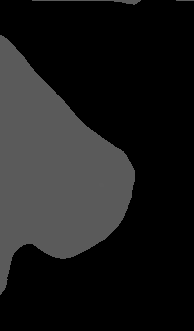

In [ ]:
#Leer imagen
rutaImagen = '/content/der.jpg'
rutaSegmentacion = '/content/mejorintento.png'
imagen = cv2.imread(rutaImagen)
segmentacion = cv2.imread(rutaSegmentacion)
cv2_imshow(imagen)
cv2_imshow(segmentacion)

****
# **Elección procesos**
****
Esta parte del código te permite utilizar las 3 técnicas de PDI asignadas a la comunidad 1, y aplicarlas en el orden deseado.
****
##### **Pasos para la aplicación de elección de procesos en orden:**

1.   Define las funciones a utilizar en una lista.
2.   Crea una lista de cadenas para mostrarsela al usuario.
3.   Crea una lista para almacenar el orden de las funciones.
4.   Muestra las opciones disponibles al usuario.
5.   Solicita al usuario ingresar el orden deseado.
6.   Convierte los valores ingresados en el orden a las respectivas funciones asignadas a ese numero y las almacena.
7.   Crea una lista para almacenar las imagenes resultantes y los histogramas de las operaciones realizadas en 6.
8.   Después de aplicar las funciones, calcula el histograma de la función resultante.
9.   Crea un gráfico para mostrar las imágenes y sus histogramas.
10.   Muestra las imagenes junto con su histograma correspondiente.

Seleccione el orden en el que desea aplicar las funciones:
1. Ecualizar la imagen
2. Filtro Promedio
3. Filtro Sobel
Ingrese el orden deseado (por ejemplo, 1 3 2): 3 2 1


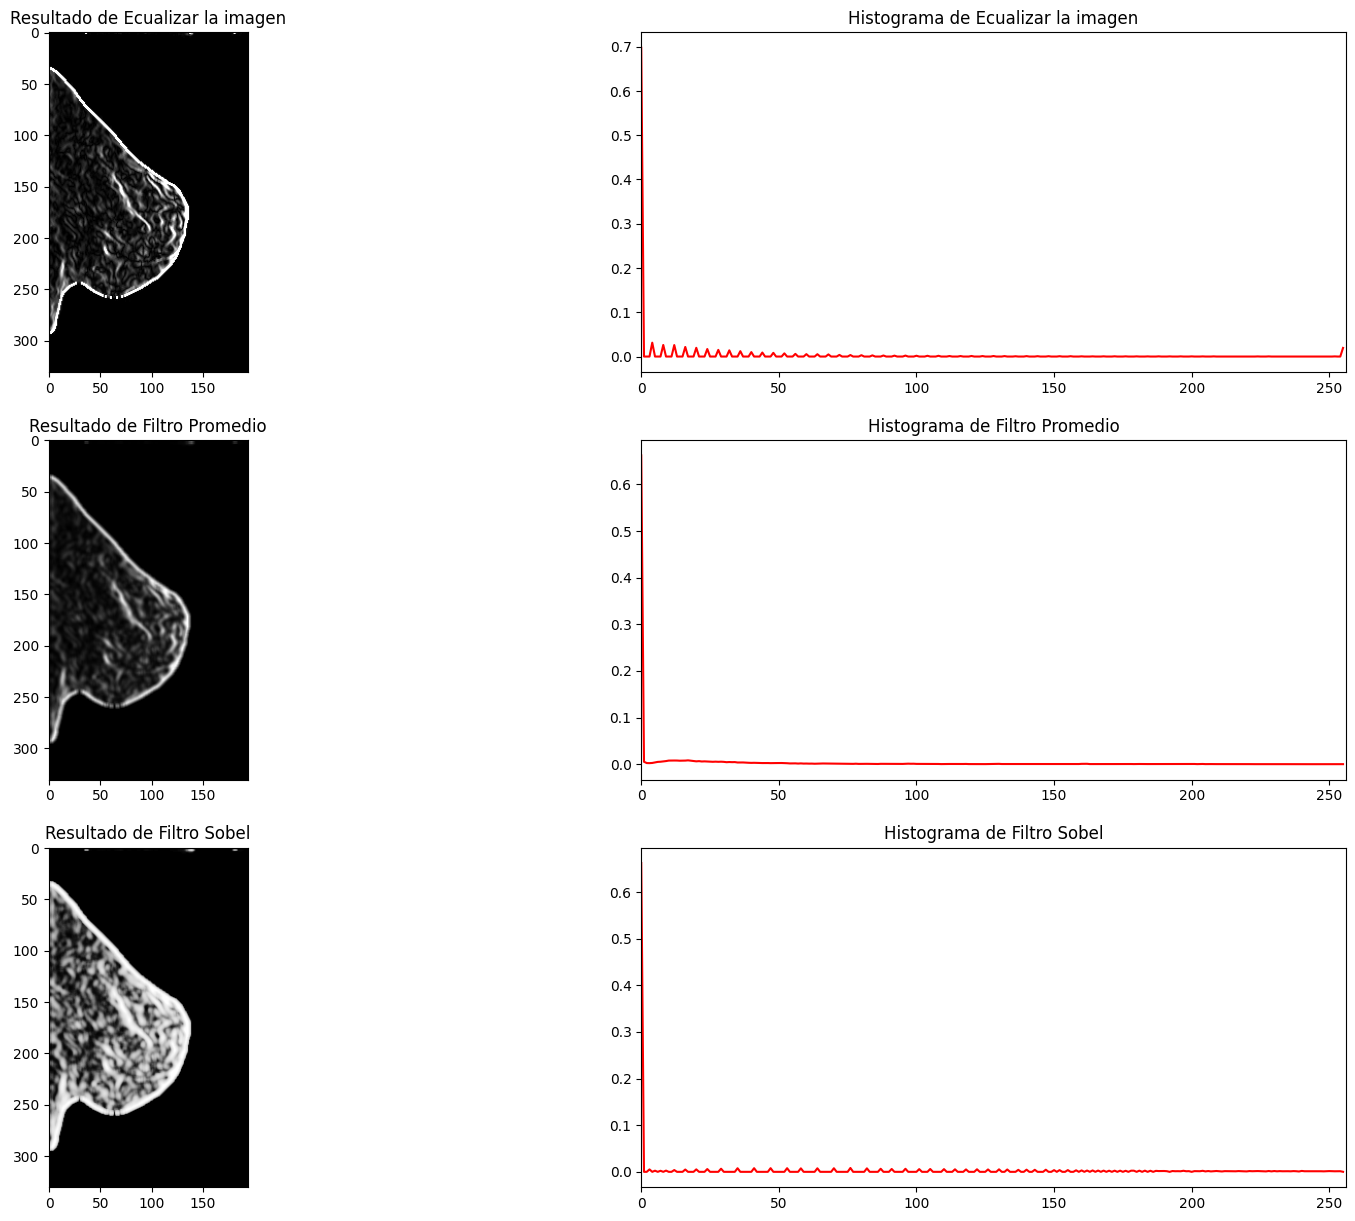

In [ ]:
# Definir las funciones en una lista
functions = [hyperbolic_equalization, filtropromedio, sobel_operator]

# Crear una lista de cadenas para mostrar las opciones al usuario
function_names = ["Ecualizar la imagen", "Filtro Promedio", "Filtro Sobel"]

# Crear una lista para almacenar el orden de las funciones
selected_order = []

# Mostrar las opciones disponibles al usuario
print("Seleccione el orden en el que desea aplicar las funciones:")
for i, function_name in enumerate(function_names, start=1):
    print(f"{i}. {function_name}")

# Solicitar al usuario que ingrese el orden deseado
order_input = input("Ingrese el orden deseado (por ejemplo, 1 3 2): ")
order_input = order_input.split()  # Convertir la entrada en una lista de números

# Convertir los números en la lista de entrada a funciones y almacenarlas en selected_order
for order in order_input:
    if order.isdigit and int(order) in range(1, len(functions) + 1):
        selected_order.append(functions[int(order) - 1])
    else:
        print(f"El número {order} no es una opción válida. Ignorado.")

# Crear una lista para almacenar las imágenes resultantes y los histogramas
result_images = [imagen]  # Comenzamos con la imagen original
histograms = []

for func in selected_order:
    if func == filtropromedio:
        kernel_size = 3
        result_image = func(result_images[-1], kernel_size)
    else:
        result_image = func(result_images[-1])
    result_images.append(result_image)

    # Calcular el histograma de la imagen resultante
    hist, _ = np.histogram(np.array(result_image).ravel(), bins=256, range=(0, 256), density=True)
    histograms.append(hist)

# Crear un gráfico para mostrar las imágenes y sus histogramas
num_functions = len(selected_order)
plt.figure(figsize=(20, 5 * num_functions))

for i in range(num_functions):
    # Mostrar la imagen resultante
    plt.subplot(num_functions, 2, i * 2 + 1)
    plt.imshow(result_images[i + 1], cmap='gray')
    plt.title(f"Resultado de {function_names[selected_order.index(selected_order[i])]}")

    # Mostrar el histograma de la imagen resultante
    plt.subplot(num_functions, 2, i * 2 + 2)
    plt.plot(histograms[i], color='r')
    plt.title(f"Histograma de {function_names[selected_order.index(selected_order[i])]}")
    plt.xlim(0, 256)

plt.show()

****
# **Umbralización**
****
La umbralización en imágenes es un proceso de segmentación que se utiliza para convertir una imagen en una imagen binaria. El objetivo de la umbralización es dividir la imagen en regiones o segmentos, donde los píxeles se clasifican como parte de un objeto de interés (frecuentemente blanco) o como fondo (frecuentemente negro), basándose en un umbral predefinido.
****
##### **Pasos para la aplicación de elección de procesos en orden:**

1.   Obtiene la última imagen generada.
2.   Muestra esa imagen en blanco y negro.
3.   Convierte la imagen a una matriz de NumPy para poder utilizarla.
4.   Aplica el umbral a la imagen (elegido de 230 a 255 para *tomar solamente los valores más altos de la imagen*).
5.   Mostrar la imagen.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

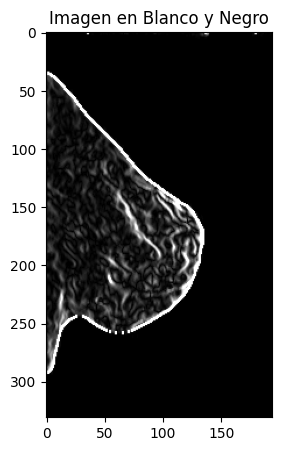

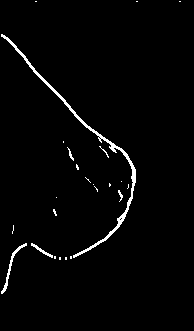

In [ ]:
# Obtener la última imagen generada
ultima_imagen = result_images[1]

# Mostrar la imagen en blanco y negro
plt.figure(figsize=(5, 5))
plt.imshow(ultima_imagen, cmap='gray')
plt.title("Imagen en Blanco y Negro")
plt.show()

# Convertir la imagen de Pillow (PIL) en una matriz de NumPy
ultima_imagen_np = np.array(ultima_imagen)

# Aplicar umbral a la imagen
_, area = cv2.threshold(ultima_imagen_np, 230, 255, cv2.THRESH_BINARY)

cv2_imshow(area)

****
# **Contorno Fallido**
****
Se intenta obtener el contorno de las masas y las calcificaciones.


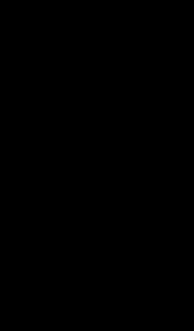

In [ ]:
# Encontrar contornos en la imagen en escala de grises
contornos, _ = cv2.findContours(area, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Crear una imagen en blanco para dibujar los contornos
contornos_img = np.zeros_like(ultima_imagen_np)

# Dibujar los contornos en la imagen en blanco
cv2.drawContours(contornos_img, contornos, -1, (0, 0, 255), thickness=1)

# Mostrar la imagen con los bordes dibujados
cv2_imshow(contornos_img)


Después de aplicar las técnicas asignadas a la comunidad 1 se observó que no se podía conseguir el contorno todavía de las masas y calcificaciones, por eso mismo se optó por utilizar el filtro Gaussiano.

****
# **Proceso de Limpieza y cargar nueva imagen**
****
La culminación de la comunidad 1 se encuentra aquí. Después de las pruebas exhaustivas para determinar la mejor combinación y después de obtener la máscara acá se aplican.
****
##### **Pasos para la aplicación del proceso de limpieza y carga de la nueva imagen en orden:**

1.   Convierte la imagen segmentada a escala de grises.
2.   Aplica un umbral para obtener una imagen binaria de la segmentación.
3.   Aplica la máscara a la imagen original para extraer la región deseada.
4.   Muestra el resultado de aplicar la máscara al usuario.



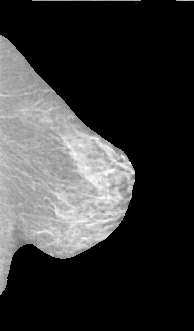

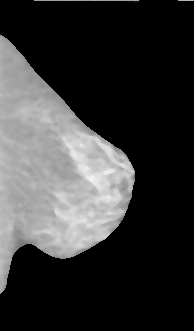

In [ ]:

# Convertir la imagen segmentada a escala de grises
imagen_segmentada_gris = cv2.cvtColor(segmentacion, cv2.COLOR_BGR2GRAY)

# Aplicar un umbral para obtener una imagen binaria de la segmentación
_, mascara = cv2.threshold(imagen_segmentada_gris, 1, 255, cv2.THRESH_BINARY)

# Aplicar la máscara a la imagen original para extraer la región
resultado = cv2.bitwise_and(imagen, imagen, mask=mascara)
cv2_imshow(resultado)

imagenSinRuido = cv2.medianBlur(resultado, ksize=5)
cv2_imshow(imagenSinRuido)

cv2.imwrite('ImagenLimpia.jpg', imagenSinRuido)

# Cargar la imagen usando Pillow (PIL)
imagen = cv2.imread('/content/ImagenLimpia.jpg')

imagen = cv2.medianBlur(imagen, ksize=5)
imagen = Image.fromarray(imagen)
#escala grises
#imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)

# Aplicar el negativo a la imagen original
imagen = apply_negative(imagen)

****
# **Contorno exitoso**
****
Aquí se consigue el contorno de las masas y calcificaciones de manera exitosa.
****
##### **Pasos para la obtención del contorno de las masas y las calcificaciones:**

1.   Consigue el umbral o máscara de la imagen original.
2.   Muestra la máscara.
3.   Se pasa de imagen BGR a escala de grises, por si las dudas.
4.   Se buscan los contornos de 3.
5.   Crea una imagen en blanco para dibujar los contornos que se vayan a obtener en 4.
6.   Dibuja los contornos obtenidos en 4, en 5.
7.   Muestra la imagen con los bordes al usuario.



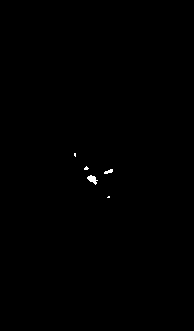

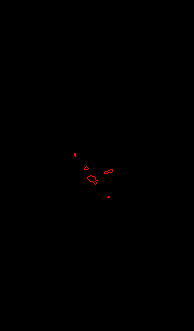

In [ ]:
# Aplicar umbral a la imagen
_, area = cv2.threshold(imagenSinRuido, 230, 255, cv2.THRESH_BINARY)

cv2_imshow(area)

area_gray = cv2.cvtColor(area, cv2.COLOR_BGR2GRAY)

# Encontrar contornos en la imagen en escala de grises
contornos, _ = cv2.findContours(area_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Crear una imagen en blanco para dibujar los contornos
contornos_img = np.zeros_like(imagenSinRuido)

# Dibujar los contornos en la imagen en blanco
cv2.drawContours(contornos_img, contornos, -1, (0, 0, 255), thickness=1)

# Mostrar la imagen con los bordes dibujados
rutaImagen = '/content/der.jpg'
imagen = cv2.imread(rutaImagen)
cv2_imshow(contornos_img)